# Feature Extraction aus InfluxDB und Klassifikation

## Imports

In [1]:
!pip install -q influxdb_client ppscore

You should consider upgrading via the '/home/sebbo/Projekte/kontextsensitive-systeme/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from influxdb_client import InfluxDBClient
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import ppscore as pps

## Daten Laden
Wier wollen die Daten direkt aus Influx Laden.
Dafür bauen wir zuerst eine Connection zur Influx Instanz auf

In [3]:
BUCKET = "extended_labels"
URL = "https://css21.teco.edu"
TOKEN = "**REMOVED**"
ORG = "css21"
client = InfluxDBClient(url=URL, token=TOKEN, org=ORG, verify_ssl=False)
query_api = client.query_api()

### Querying Influx
Der Query wird in Flux geschrieben

In [19]:
query = '''
    from(bucket: bucket)
      |> range(start: -30d, stop: now())
      |> filter(fn: (r) => r.label != "testing")
      |> pivot(rowKey: ["_time", "label", "subject"], columnKey: ["_field", "_measurement"], valueColumn: "_value")
'''
params = {
    "bucket": BUCKET
}
result = query_api.query_data_frame(query, params=params)
result = result.set_index("_time", drop=True)
result = result.drop(columns=["table", "result", "_start", "_stop", "browser", "mobile"])
result["label"] = pd.Categorical(result["label"])
result


/home/sebbo/Projekte/kontextsensitive-systeme/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'css21.teco.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


,label,subject,alpha_devicemotion,beta_devicemotion,gamma_devicemotion,x_devicemotion,x0_devicemotion,y_devicemotion,y0_devicemotion,z_devicemotion,z0_devicemotion,alpha_deviceorientation,beta_deviceorientation,gamma_deviceorientation
_time,,,,,,,,,,,,,,
2021-08-14 11:58:37.871000+00:00,driving,0c86078c3e,23.695926,-41.337541,-9.004711,0.774075,0.479989,-5.938367,0.633047,-9.519047,-2.245780,NaN,NaN,NaN
2021-08-14 11:58:37.887000+00:00,driving,0c86078c3e,52.862054,-18.493067,-2.514026,0.685190,0.455864,-6.186018,0.483131,-9.409512,-2.223397,NaN,NaN,NaN
2021-08-14 11:58:37.903000+00:00,driving,0c86078c3e,65.476283,4.852037,-1.505551,0.137966,-0.083518,-5.850979,0.967563,-8.309975,-1.265203,NaN,NaN,NaN
2021-08-14 11:58:37.920000+00:00,driving,0c86078c3e,59.653137,3.318965,-8.634220,-0.124648,-0.371062,-6.084713,0.887691,-7.275830,-0.384150,NaN,NaN,NaN
2021-08-14 11:58:37.937000+00:00,driving,0c86078c3e,51.026444,-1.898931,-12.700321,-0.046388,-0.306667,-6.291212,0.746649,-6.849212,-0.024907,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-21 11:42:30.367000+00:00,studying,hj44jjh740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.368002,52.924892,-9.198874
2021-08-21 11:42:30.383000+00:00,studying,hj44jjh740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.306407,53.026791,-9.471686
2021-08-21 11:42:30.400000+00:00,studying,hj44jjh740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.221469,52.874954,-9.370203


## Feature Extraction

In [5]:
grouped = result.groupby(["label", "subject",pd.Grouper(freq='1s')])
mean = grouped.mean()
sum = grouped.sum()
std = grouped.std()
max = grouped.max()
min = grouped.min()
res = mean.join(sum, lsuffix="_mean").join(std, lsuffix="_sum").join(max, lsuffix='_std').join(min, lsuffix="_max", rsuffix="_min")
res = res.reset_index().dropna()
res

,label,subject,_time,alpha_devicemotion_mean,beta_devicemotion_mean,gamma_devicemotion_mean,x_devicemotion_mean,x0_devicemotion_mean,y_devicemotion_mean,y0_devicemotion_mean,...,gamma_devicemotion_min,x_devicemotion_min,x0_devicemotion_min,y_devicemotion_min,y0_devicemotion_min,z_devicemotion_min,z0_devicemotion_min,alpha_deviceorientation_min,beta_deviceorientation_min,gamma_deviceorientation_min
923510,sleeping,caj9gc374c,2021-08-31 21:38:32+00:00,-6.527500,45.965986,17.614218,-5.820846,-0.016370,-5.851025,-0.255882,...,-21.963771,-7.535153,-1.408584,-7.089232,-2.154051,-7.713069,-0.735445,17.750543,25.760434,-64.968309
923511,sleeping,caj9gc374c,2021-08-31 21:38:33+00:00,-20.620591,32.609602,24.964860,-0.655143,0.314231,-0.744345,0.228235,...,-0.146172,-6.909518,-2.829620,-5.228039,-1.821052,-17.846379,-8.067375,35.237137,0.642835,-29.862383
923512,sleeping,caj9gc374c,2021-08-31 21:38:34+00:00,-0.000184,-0.015300,0.010943,-0.040566,0.052705,-0.299861,-0.017623,...,-0.166993,-0.070481,0.028149,-0.309600,-0.036615,-9.801413,0.000732,54.274692,1.592105,-0.722087
923513,sleeping,caj9gc374c,2021-08-31 21:38:35+00:00,0.016714,-0.003238,-0.013306,-0.039381,0.020418,-0.298993,-0.004958,...,-0.180155,-0.050579,0.001852,-0.307804,-0.017622,-9.802460,-0.000419,54.268150,1.693025,-0.410177
923514,sleeping,caj9gc374c,2021-08-31 21:38:36+00:00,0.015532,-0.007422,-0.009618,-0.038945,0.007902,-0.296918,0.000862,...,-0.166556,-0.047736,-0.002848,-0.304811,-0.007025,-9.797372,0.004633,54.264401,1.736956,-0.302509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923958,studying,0f7dfg1ib5,2021-08-26 13:28:18+00:00,-0.001374,-0.005984,-0.018565,-0.021456,-0.000925,-0.056476,0.000590,...,-0.199698,-0.036661,-0.016767,-0.070180,-0.013227,-9.811588,-0.005119,33.265172,0.327522,-0.122735
923959,studying,0f7dfg1ib5,2021-08-26 13:28:19+00:00,0.006528,0.007716,0.002133,-0.020635,-0.000756,-0.056680,0.000586,...,-0.147649,-0.033968,-0.014096,-0.072574,-0.015513,-9.814131,-0.007670,33.269208,0.331108,-0.121469
923960,studying,0f7dfg1ib5,2021-08-26 13:28:20+00:00,-0.001359,-0.000142,0.023002,-0.021840,-0.001372,-0.056523,0.000449,...,-0.150277,-0.036212,-0.015451,-0.077064,-0.019737,-9.816227,-0.009766,33.279747,0.328290,-0.124541
923961,studying,0f7dfg1ib5,2021-08-26 13:28:21+00:00,-0.001865,-0.005708,-0.001870,-0.020515,-0.000418,-0.057089,-0.000261,...,-0.202589,-0.049231,-0.028621,-0.086491,-0.028776,-9.819967,-0.013504,33.289370,0.327717,-0.120762


In [7]:
# Add time features
res["hour_sin"] = np.sin(res['_time'].dt.hour * 2 * np.pi / 24)
res["hour_cos"] = np.cos(res['_time'].dt.hour * 2 * np.pi / 24)

## Analysis

First, we are going to take a look at the distribution of our classes. Optimally, our dataset would be balanced between all classes, but having a decent amount of examples for every class, is a good start.

In [8]:
df = res

<AxesSubplot:xlabel='label', ylabel='count'>

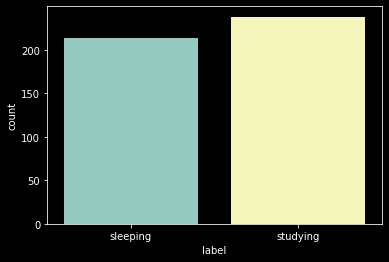

In [9]:
sns.countplot(x=df["label"])


###  Subjects
Getting the different subjects

In [10]:
subjects = df['subject'].unique()
subjects

array(['caj9gc374c', '0f7dfg1ib5'], dtype=object)

In [11]:
# Splitting them in test and train subjects
train_subjects, test_subjects = train_test_split(subjects)
train_subjects

array(['caj9gc374c'], dtype=object)

### Device Motion
Next we are going to look at the devicemotion values.

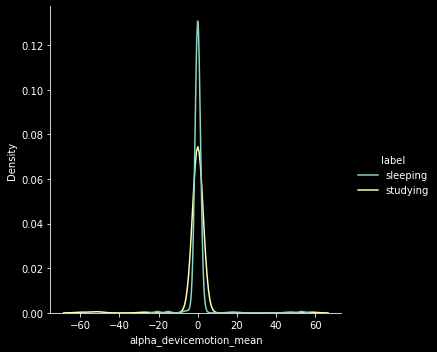

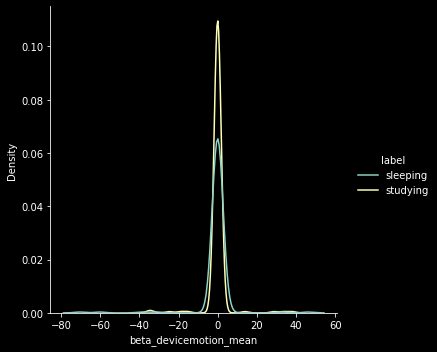

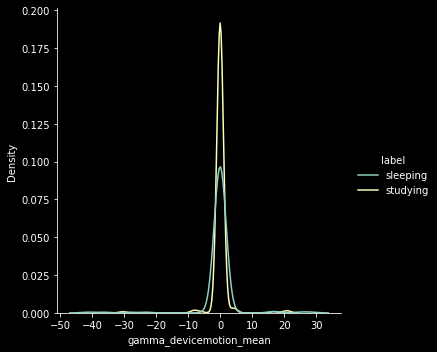

In [12]:
for var in ["alpha_devicemotion_mean", "beta_devicemotion_mean", "gamma_devicemotion_mean"]:
  sns.displot(df, x=var, hue="label", kind="kde")

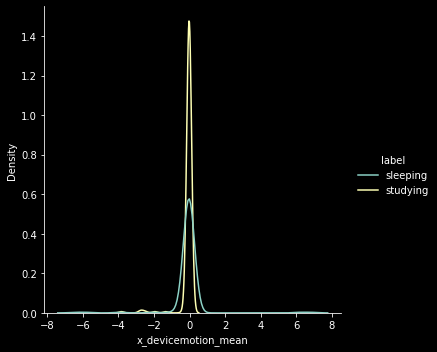

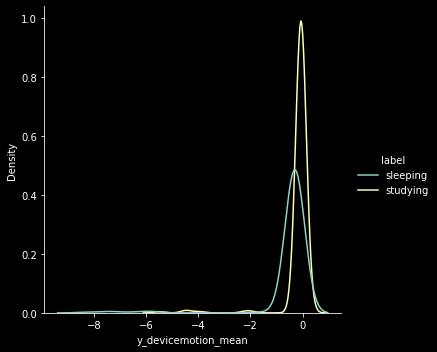

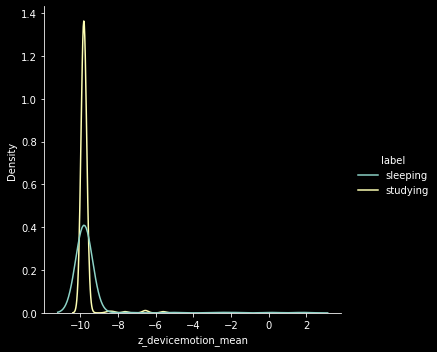

In [13]:
for var in ["x", "y", "z"]:
  sns.displot(df, x=f"{var}_devicemotion_mean", hue="label", kind="kde")

<AxesSubplot:>

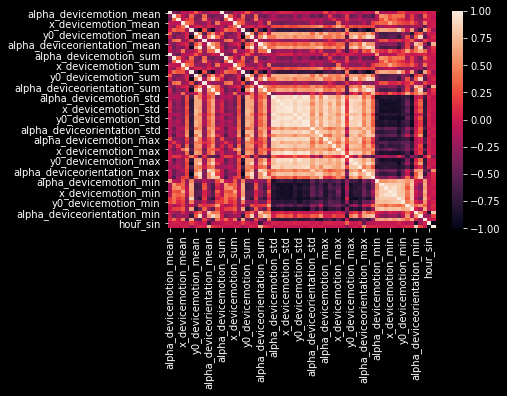

In [14]:
cor = df.corr()
sns.heatmap(cor)

<AxesSubplot:xlabel='x', ylabel='y'>

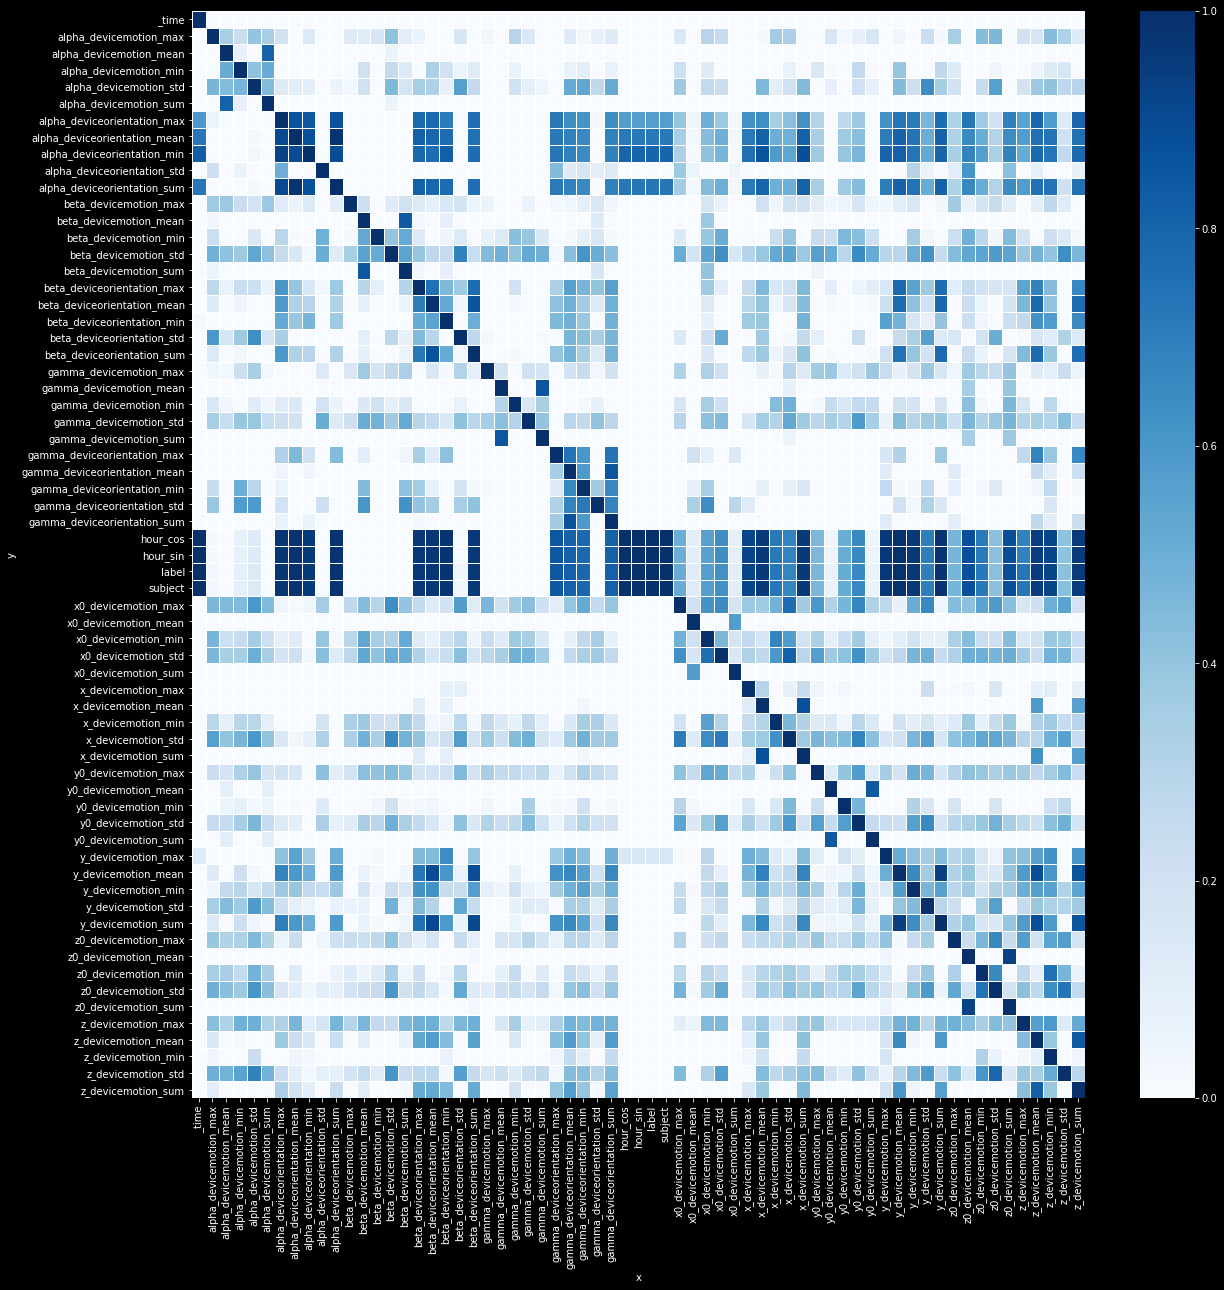

In [15]:
fig, ax = plt.subplots(figsize=(20,20))    
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, ax=ax, annot=False)

## Converting to Datasets

In [16]:
df_train = df[df["subject"].isin(train_subjects)]
df_test = df[df["subject"].isin(test_subjects)]

y_train, y_test = df_train["label"], df_test["label"]
X_train, X_test = df_train.drop(columns=["label", "subject", "_time"]), df_test.drop(columns=["label", "subject", "_time"])

In [17]:
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('dummy', DummyClassifier(strategy="most_frequent"))])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.0

In [18]:

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

ValueError: The number of classes has to be greater than one; got 1 class